# Generate Custom Feature Importance Plots (for AutoMLPipe-BC)
Generates custom feature importance plots: (1) to include all features in the dataset or (2) to provide a way to generate modified versions of these plots without rerunning or directly editing the code in the original pipeline. 

Designed to operate following application of pipeline phases 1-6. Relies on folder/file hierarchy saved by the pipeline.
 

## Import Packages

In [1]:
import os
import pandas as pd
import pickle
from statistics import mean,stdev
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Set Run Parameters

In [2]:
experiment_path = "C:/Users/ryanu/Documents/Analysis/AutoMLPipe_Experiments/hcc_demo"
targetDataName = 'None' # 'None' if user wants to generate visualizations for all analyzed datasets
algorithms = [] #use empty list if user wishes to plot feature importance for all modeling algorithms that were run in pipeline.
top_results = None # None - to plot all features in original dataset, or specify some (int) to indicate # of top features to plot.
name_modifier = '_AllFeatures' # Modifies standard composite FI plot filename to avoid overwriting originals.
viz_norm_only = True #Generate plot with only FI normalization
viz_norm_weight = True #Generate plot with FI normalization and performance metric weighting
viz_norm_frac = True #Generate plot with FI normalization and fractionation (each algorithm has limited bar area to distribute in plot)
viz_norm_weight_frac = True #Generate plot with FI normalization performance metric weighting and fractionation
legend_inside_plot = True #place legend ouside plot in upper right hand corner, other wise placed inside on upper right hand corner.

#available_algorithms = ['Naive Bayes','Logistic Regression','Decision Tree','Random Forest','Gradient Boosting','XGB','LGB','SVM','ANN','K Neighbors','eLCS','XCS','ExSTraCS']

## Automatically detect data folder names

In [3]:
# Get dataset paths for all completed dataset analyses in experiment folder
datasets = os.listdir(experiment_path)
experiment_name = experiment_path.split('/')[-1] #Name of experiment folder
datasets.remove('metadata.csv')
try:
    datasets.remove('jobsCompleted')
except:
    pass
try:
    datasets.remove('UsefulNotebooks')
except:
    pass
try:
    datasets.remove('logs')
    datasets.remove('jobs')
except:
    pass
try:
    datasets.remove('DatasetComparisons') #If it has been run previously (overwrite)
except:
    pass
try:
    datasets.remove('KeyFileCopy') #If it has been run previously (overwrite)
except:
    pass
try:
    datasets.remove(experiment_name+'_ML_Pipeline_Report.pdf') #If it has been run previously (overwrite)
except:
    pass
datasets = sorted(datasets) #ensures consistent ordering of datasets
print("Analyzed Datasets: "+str(datasets))

Analyzed Datasets: ['hcc-data_example', 'hcc-data_example_no_covariates']


## Load other necessary parameters

In [4]:
#Load variables specified earlier in the pipeline from metadata file
jupyterRun = 'True'
metadata = pd.read_csv(experiment_path + '/' + 'metadata.csv').values
class_label = metadata[0, 1]
instance_label = metadata[1, 1]
cv_partitions = int(metadata[6,1])
do_NB = metadata[20,1]
do_LR = metadata[21,1]
do_DT = metadata[22,1]
do_RF = metadata[23,1]
do_GB = metadata[24, 1]
do_XGB = metadata[25,1]
do_LGB = metadata[26,1]
do_SVM = metadata[27,1]
do_ANN = metadata[28,1]
do_KN = metadata[29, 1]
do_eLCS = metadata[30,1]
do_XCS = metadata[31,1]
do_ExSTraCS = metadata[32,1]
primary_metric = metadata[33,1]

possible_algos = ['Naive Bayes','Logistic Regression','Decision Tree','Random Forest','Gradient Boosting','XGB','LGB','SVM','ANN','K Neighbors','eLCS','XCS','ExSTraCS']
abbrev = {'Naive Bayes':'NB','Logistic Regression':'LR','Decision Tree':'DT','Random Forest':'RF','Gradient Boosting':'GB','XGB':'XGB','LGB':'LGB','SVM':'SVM','ANN':'ANN','K Neighbors':'KN','eLCS':'eLCS','XCS':'XCS','ExSTraCS':'ExSTraCS'}
colors = {'Naive Bayes':'grey','Logistic Regression':'black','Decision Tree':'yellow','Random Forest':'orange','Gradient Boosting':'bisque','XGB':'purple','LGB':'aqua','SVM':'blue','ANN':'red','eLCS':'firebrick','XCS':'deepskyblue','K Neighbors':'seagreen','ExSTraCS':'lightcoral'}

#Create algorithms list (i.e. modeling algorithms that were run in the pipeline)
if eval(do_NB):
    algorithms.append('Naive Bayes')
if eval(do_LR):
    algorithms.append('Logistic Regression')
if eval(do_DT):
    algorithms.append('Decision Tree')
if eval(do_RF):
    algorithms.append('Random Forest')
if eval(do_GB):
    algorithms.append('Gradient Boosting')
if eval(do_XGB):
    algorithms.append('XGB')
if eval(do_LGB):
    algorithms.append('LGB')
if eval(do_SVM):
    algorithms.append('SVM')
if eval(do_ANN):
    algorithms.append('ANN')
if eval(do_KN):
    algorithms.append('K Neighbors')
if eval(do_eLCS):
    algorithms.append('eLCS')
if eval(do_XCS):
    algorithms.append('XCS')
if eval(do_ExSTraCS):
    algorithms.append('ExSTraCS')
    
print(algorithms)

['Naive Bayes', 'Logistic Regression', 'Decision Tree']


## Define necessary methods

In [5]:
def primaryStats(algorithms,original_headers,cv_partitions,full_path,data_name,instance_label,class_label,abbrev):
    """ Combine classification metrics and model feature importance scores"""
    metric_dict = {}
    for algorithm in algorithms: #completed for each individual ML modeling algorithm
        # Define evaluation stats variable lists
        s_bac = [] # balanced accuracies
        s_ac = [] # standard accuracies
        s_f1 = [] # F1 scores
        s_re = [] # recall values
        s_sp = [] # specificities
        s_pr = [] # precision values
        s_tp = [] # true positives
        s_tn = [] # true negatives
        s_fp = [] # false positives
        s_fn = [] # false negatives
        s_npv = [] # negative predictive values
        s_lrp = [] # likelihood ratio positive values
        s_lrm = [] # likelihood ratio negative values
        aucs = [] #areas under ROC curve
        praucs = [] #area under PRC curve
        aveprecs = [] #average precisions for PRC
        
        # Define feature importance lists
        FI_all = [] # used to save model feature importances individually for each cv within single summary file (all original features in dataset prior to feature selection included)
        FI_ave = [0] * len(original_headers)  # used to save average FI scores over all cvs. (all original features in dataset prior to feature selection included)
        #Gather statistics over all CV partitions
        for cvCount in range(0,cv_partitions):
            #Unpickle saved metrics from previous phase
            result_file = full_path+'/model_evaluation/pickled_metrics/'+abbrev[algorithm]+"_CV_"+str(cvCount)+"_metrics"
            file = open(result_file, 'rb')
            results = pickle.load(file)
            file.close()
            #Separate pickled results
            metricList = results[0]
            roc_auc = results[3]
            prec_rec_auc = results[6]
            ave_prec = results[7]
            fi = results[8]
            #Separate metrics from metricList
            s_bac.append(metricList[0])
            s_ac.append(metricList[1])
            s_f1.append(metricList[2])
            s_re.append(metricList[3])
            s_sp.append(metricList[4])
            s_pr.append(metricList[5])
            s_tp.append(metricList[6])
            s_tn.append(metricList[7])
            s_fp.append(metricList[8])
            s_fn.append(metricList[9])
            s_npv.append(metricList[10])
            s_lrp.append(metricList[11])
            s_lrm.append(metricList[12])
            aucs.append(roc_auc)
            praucs.append(prec_rec_auc)
            aveprecs.append(ave_prec)
            
            # Format feature importance scores as list (takes into account that all features are not in each CV partition)
            tempList = []
            j = 0
            headers = pd.read_csv(full_path+'/CVDatasets/'+data_name+'_CV_'+str(cvCount)+'_Test.csv').columns.values.tolist()
            if instance_label != 'None':
                headers.remove(instance_label)
            headers.remove(class_label)
            for each in original_headers:
                if each in headers:  # Check if current feature from original dataset was in the partition
                    # Deal with features not being in original order (find index of current feature list.index()
                    f_index = headers.index(each)
                    FI_ave[j] += fi[f_index]
                    tempList.append(fi[f_index])
                else:
                    tempList.append(0)
                j += 1
            FI_all.append(tempList)
        #Export and save all CV metric stats for each individual algorithm  -----------------------------------------------------------------------------
        results = {'Balanced Accuracy': s_bac, 'Accuracy': s_ac, 'F1_Score': s_f1, 'Sensitivity (Recall)': s_re, 'Specificity': s_sp,'Precision (PPV)': s_pr, 'TP': s_tp, 'TN': s_tn, 'FP': s_fp, 'FN': s_fn, 'NPV': s_npv, 'LR+': s_lrp, 'LR-': s_lrm, 'ROC_AUC': aucs,'PRC_AUC': praucs, 'PRC_APS': aveprecs}
        metric_dict[algorithm] = results

        #Turn FI sums into averages
        for i in range(0, len(FI_ave)):
            FI_ave[i] = FI_ave[i] / float(cv_partitions)

    return metric_dict


In [6]:
def prepFI(algorithms,full_path,abbrev,metric_dict,primary_metric):
    """ Organizes and prepares model feature importance data for boxplot and composite feature importance figure generation."""
    #Initialize required lists
    fi_df_list = []         # algorithm feature importance dataframe list (used to generate FI boxplots for each algorithm)
    fi_ave_list = []        # algorithm feature importance averages list (used to generate composite FI barplots)
    ave_metric_list = []    # algorithm focus metric averages list (used in weighted FI viz)
    all_feature_list = []   # list of pre-feature selection feature names as they appear in FI reports for each algorithm
    #Get necessary feature importance data and primary metric data (currenly only 'balanced accuracy' can be used for this)
    for algorithm in algorithms:
        # Get relevant feature importance info
        temp_df = pd.read_csv(full_path+'/model_evaluation/feature_importance/'+abbrev[algorithm]+"_FI.csv") #CV FI scores for all original features in dataset.
        if algorithm == algorithms[0]:  # Should be same for all algorithm files (i.e. all original features in standard CV dataset order)
            all_feature_list = temp_df.columns.tolist()
        fi_df_list.append(temp_df)
        fi_ave_list.append(temp_df.mean().tolist()) #Saves average FI scores over CV runs
        # Get relevant metric info
        avgBA = mean(metric_dict[algorithm][primary_metric])
        ave_metric_list.append(avgBA)
    #Normalize Average Feature importance scores so they fall between (0 - 1)
    fi_ave_norm_list = []
    for each in fi_ave_list:  # each algorithm
        normList = []
        for i in range(len(each)): #each feature (score) in original data order
            if each[i] <= 0: #Feature importance scores assumed to be uninformative if at or below 0
                normList.append(0)
            else:
                normList.append((each[i]) / (max(each)))
        fi_ave_norm_list.append(normList)
    #Identify features with non-zero averages (step towards excluding features that had zero feature importance for all algorithms)
    alg_non_zero_FI_list = [] #stores list of feature name lists that are non-zero for each algorithm
    for each in fi_ave_list:  # each algorithm
        temp_non_zero_list = []
        for i in range(len(each)):  # each feature
            if each[i] > 0.0:
                temp_non_zero_list.append(all_feature_list[i]) #add feature names with positive values (doesn't need to be normalized for this)
        alg_non_zero_FI_list.append(temp_non_zero_list)
    non_zero_union_features = alg_non_zero_FI_list[0]  # grab first algorithm's list
    #Identify union of features with non-zero averages over all algorithms (i.e. if any algorithm found a non-zero score it will be considered for inclusion in top feature visualizations)
    for j in range(1, len(algorithms)):
        non_zero_union_features = list(set(non_zero_union_features) | set(alg_non_zero_FI_list[j]))
    non_zero_union_indexes = []
    for i in non_zero_union_features:
        non_zero_union_indexes.append(all_feature_list.index(i))
    return fi_df_list,fi_ave_norm_list,ave_metric_list,all_feature_list,non_zero_union_features,non_zero_union_indexes

In [7]:
def selectForViz(top_results,non_zero_union_features,non_zero_union_indexes,algorithms,ave_metric_list,fi_ave_norm_list):
    """ Identify list of top features over all algorithms to visualize (note that best features to vizualize are chosen using algorithm performance weighting and normalization:
    frac plays no useful role here only for viz). All features included if there are fewer than 'top_results'. Top features are determined by the sum of performance
    (i.e. balanced accuracy) weighted feature importances over all algorithms."""
    featuresToViz = None
    #Create performance weighted score sum dictionary for all features
    scoreSumDict = {}
    i = 0
    for each in non_zero_union_features:  # for each non-zero feature
        for j in range(len(algorithms)):  # for each algorithm
            # grab target score from each algorithm
            score = fi_ave_norm_list[j][non_zero_union_indexes[i]]
            # multiply score by algorithm performance weight
            weight = ave_metric_list[j]
            if weight <= .5:
                weight = 0
            if not weight == 0:
                weight = (weight - 0.5) / 0.5
            score = score * weight
            #score = score * ave_metric_list[j]
            if not each in scoreSumDict:
                scoreSumDict[each] = score
            else:
                scoreSumDict[each] += score
        i += 1
    # Sort features by decreasing score
    scoreSumDict_features = sorted(scoreSumDict, key=lambda x: scoreSumDict[x], reverse=True)
    if top_results == None or not len(non_zero_union_features) > top_results:
        featuresToViz = scoreSumDict_features
    else:
        featuresToViz = scoreSumDict_features[0:top_results]

    return featuresToViz #list of feature names to vizualize in composite FI plots.

In [8]:
def getFI_To_Viz_Sorted(featuresToViz,all_feature_list,algorithms,fi_ave_norm_list):
    """ Takes a list of top features names for vizualization, gets their indexes. In every composite FI plot features are ordered the same way
    they are selected for vizualization (i.e. normalized and performance weighted). Because of this feature bars are only perfectly ordered in
    descending order for the normalized + performance weighted composite plot. """
    #Get original feature indexs for selected feature names
    feature_indexToViz = [] #indexes of top features
    for i in featuresToViz:
        feature_indexToViz.append(all_feature_list.index(i))
    # Create list of top feature importance values in original dataset feature order
    top_fi_ave_norm_list = [] #feature importance values of top features for each algorithm (list of lists)
    for i in range(len(algorithms)):
        tempList = []
        for j in feature_indexToViz: #each top feature index
            tempList.append(fi_ave_norm_list[i][j]) #add corresponding FI value
        top_fi_ave_norm_list.append(tempList)
    all_feature_listToViz = featuresToViz
    return top_fi_ave_norm_list,all_feature_listToViz

In [9]:
def composite_FI_plot(fi_list, algorithms, algColors, all_feature_listToViz, figName,full_path,jupyterRun,yLabelText,name_modifier,legend_inside_plot):
    """ Generate composite feature importance plot given list of feature names and associated feature importance scores for each algorithm.
    This is run for different transformations of the normalized feature importance scores. """
    # Set basic plot properites
    rc('font', weight='bold', size=16)
    # The position of the bars on the x-axis
    r = all_feature_listToViz #feature names
    #Set width of bars
    barWidth = 0.75
    #Set figure dimensions
    plt.figure(figsize=(24, 12))
    #Plot first algorithm FI scores (lowest) bar
    p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
    #Automatically calculate space needed to plot next bar on top of the one before it
    bottoms = [] #list of space used by previous algorithms for each feature (so next bar can be placed directly above it)
    for i in range(len(algorithms) - 1):
        for j in range(i + 1):
            if j == 0:
                bottom = np.array(fi_list[0])
            else:
                bottom += np.array(fi_list[j])
        bottoms.append(bottom)
    if not isinstance(bottoms, list):
        bottoms = bottoms.tolist()
    #Plot subsequent feature bars for each subsequent algorithm
    ps = [p1[0]]
    for i in range(len(algorithms) - 1):
        p = plt.bar(r, fi_list[i + 1], bottom=bottoms[i], color=algColors[i + 1], edgecolor='white', width=barWidth)
        ps.append(p[0])
    lines = tuple(ps)
    # Specify axes info and legend
    plt.xticks(np.arange(len(all_feature_listToViz)), all_feature_listToViz, rotation='vertical')
    plt.xlabel("Feature", fontsize=20)
    plt.ylabel(yLabelText, fontsize=20)
    if legend_inside_plot:
        plt.legend(lines[::-1], algorithms[::-1],loc="upper right")
    else:
        plt.legend(lines[::-1], algorithms[::-1],loc="upper left", bbox_to_anchor=(1.01,1))
    #Export and/or show plot
    plt.savefig(full_path+'/model_evaluation/feature_importance/Compare_FI_' + figName +name_modifier+ '.png', bbox_inches='tight')
    if eval(jupyterRun):
        plt.show()
    else:
        plt.close('all')

In [10]:
def fracFI(top_fi_ave_norm_list):
    """ Transforms feature scores so that they sum to 1 over all features for a given algorithm.  This way the normalized and fracionated composit bar plot
    offers equal total bar area for every algorithm. The intuition here is that if an algorithm gives the same FI scores for all top features it won't be
    overly represented in the resulting plot (i.e. all features can have the same maximum feature importance which might lead to the impression that an
    algorithm is working better than it is.) Instead, that maximum 'bar-real-estate' has to be divided by the total number of features. Notably, this
    transformation has the potential to alter total algorithm FI bar height ranking of features. """
    fracLists = []
    for each in top_fi_ave_norm_list: #each algorithm
        fracList = []
        for i in range(len(each)): #each feature
            if sum(each) == 0: #check that all feature scores are not zero to avoid zero division error
                fracList.append(0)
            else:
                fracList.append((each[i] / (sum(each))))
        fracLists.append(fracList)
    return fracLists

In [11]:
def weightFI(ave_metric_list,top_fi_ave_norm_list):
    """ Weights the feature importance scores by algorithm performance (intuitive because when interpreting feature importances we want to place more weight on better performing algorithms) """
    # Prepare weights
    weights = []
    # replace all balanced accuraces <=.5 with 0 (i.e. these are no better than random chance)
    for i in range(len(ave_metric_list)):
        if ave_metric_list[i] <= .5:
            ave_metric_list[i] = 0
    # normalize balanced accuracies
    for i in range(len(ave_metric_list)):
        if ave_metric_list[i] == 0:
            weights.append(0)
        else:
            weights.append((ave_metric_list[i] - 0.5) / 0.5)
    # Weight normalized feature importances
    weightedLists = []
    for i in range(len(top_fi_ave_norm_list)): #each algorithm
        weightList = np.multiply(weights[i], top_fi_ave_norm_list[i]).tolist()
        weightedLists.append(weightList)
    return weightedLists,weights

In [12]:
def weightFracFI(fracLists,weights):
    """ Weight normalized and fractionated feature importances. """
    weightedFracLists = []
    for i in range(len(fracLists)):
        weightList = np.multiply(weights[i], fracLists[i]).tolist()
        weightedFracLists.append(weightList)
    return weightedFracLists

## Generate composite feature importance plots

---------------------------------------
hcc-data_example
---------------------------------------


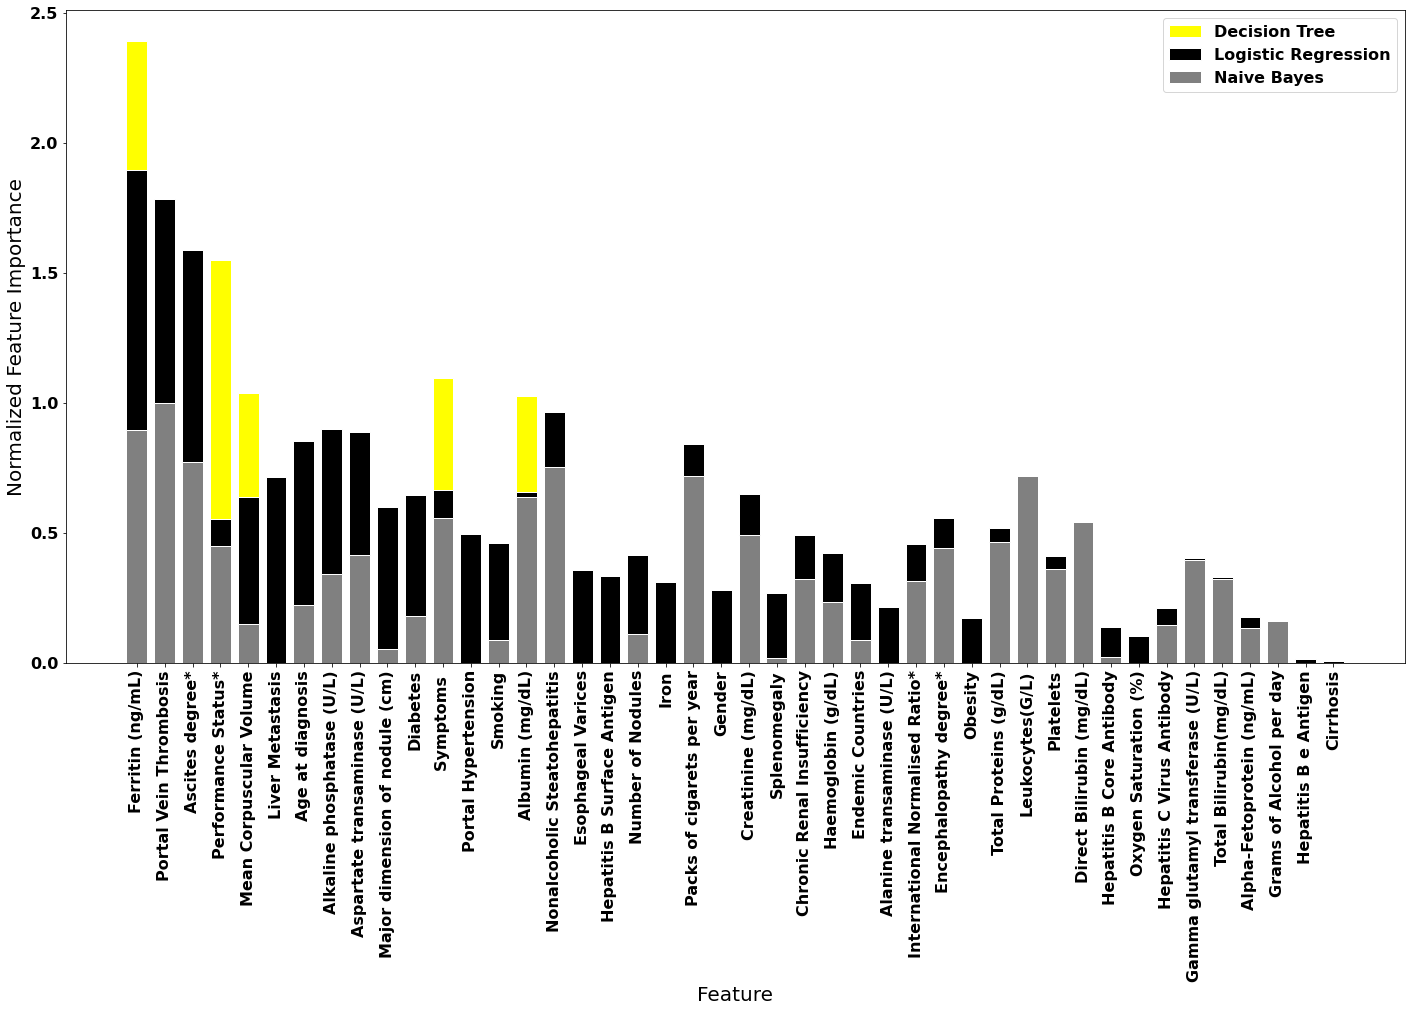

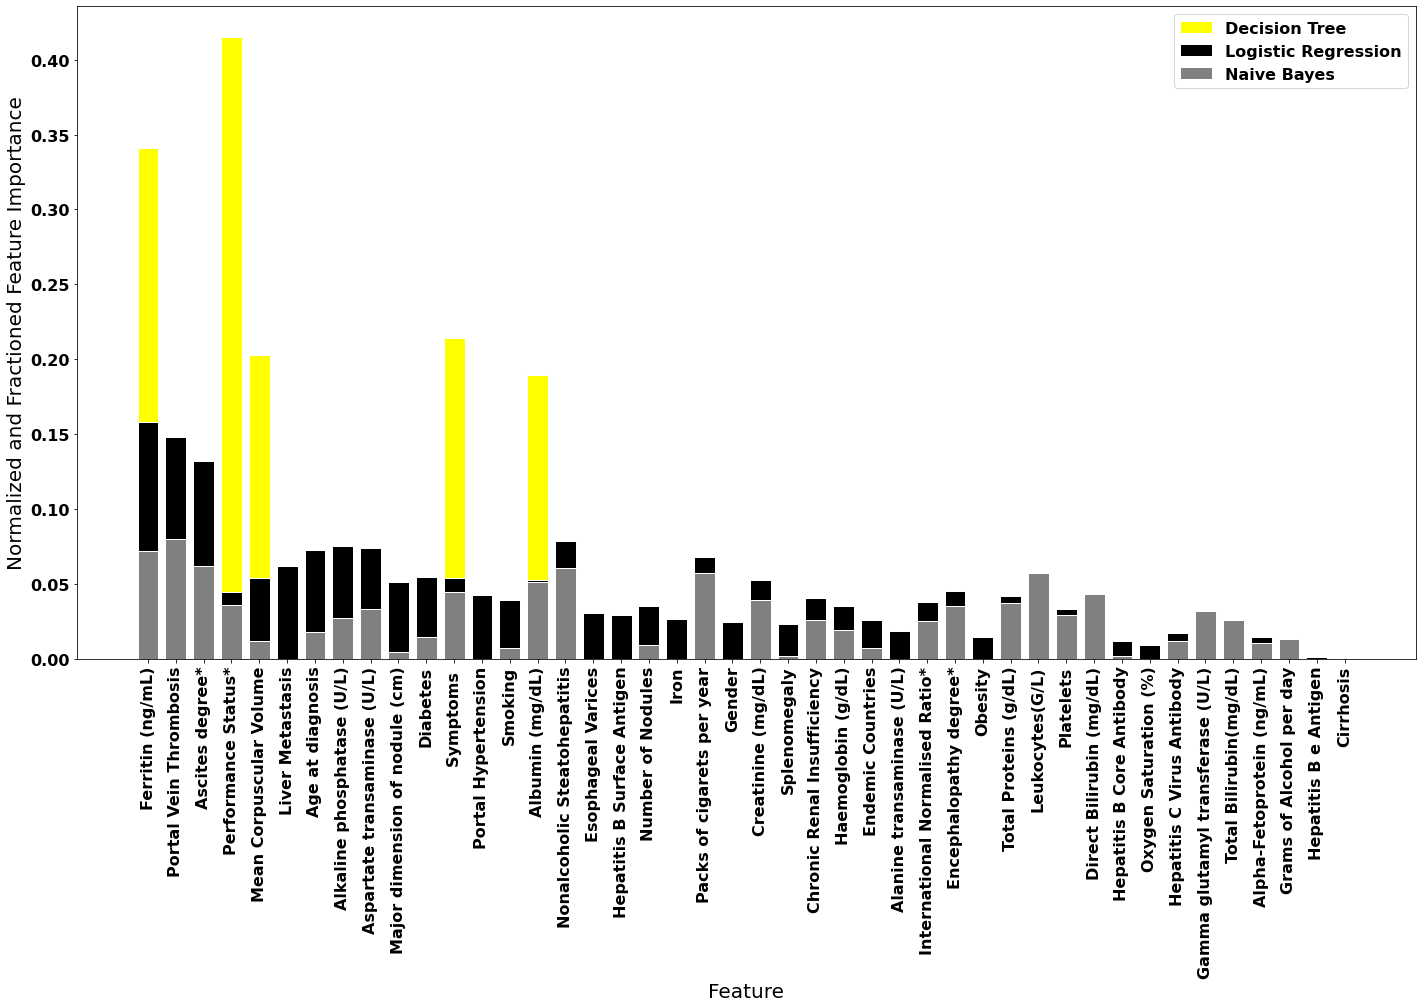

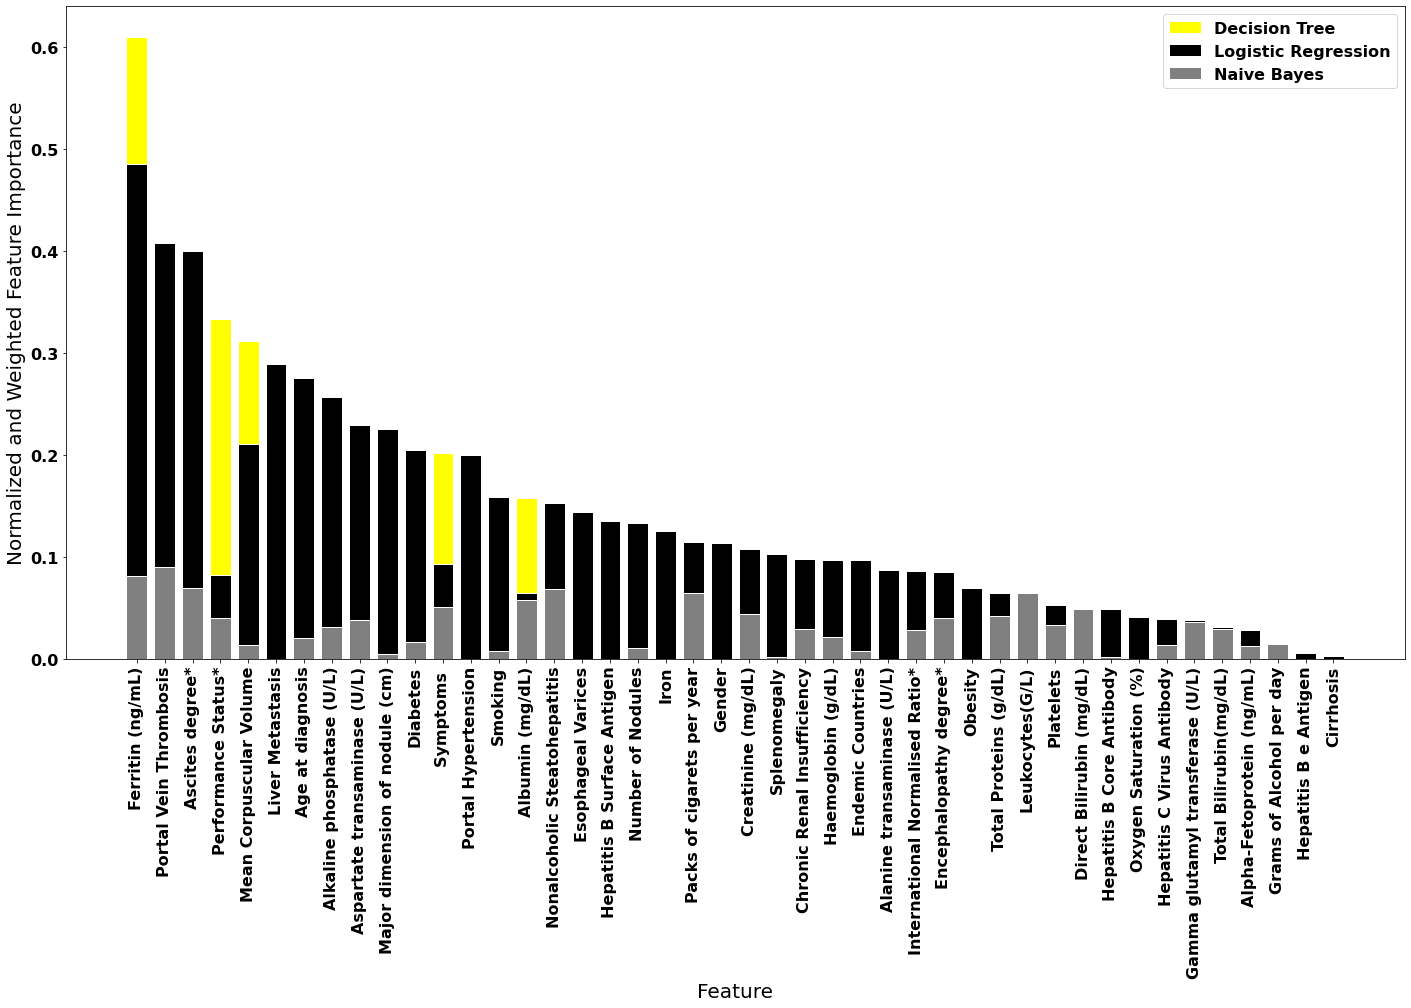

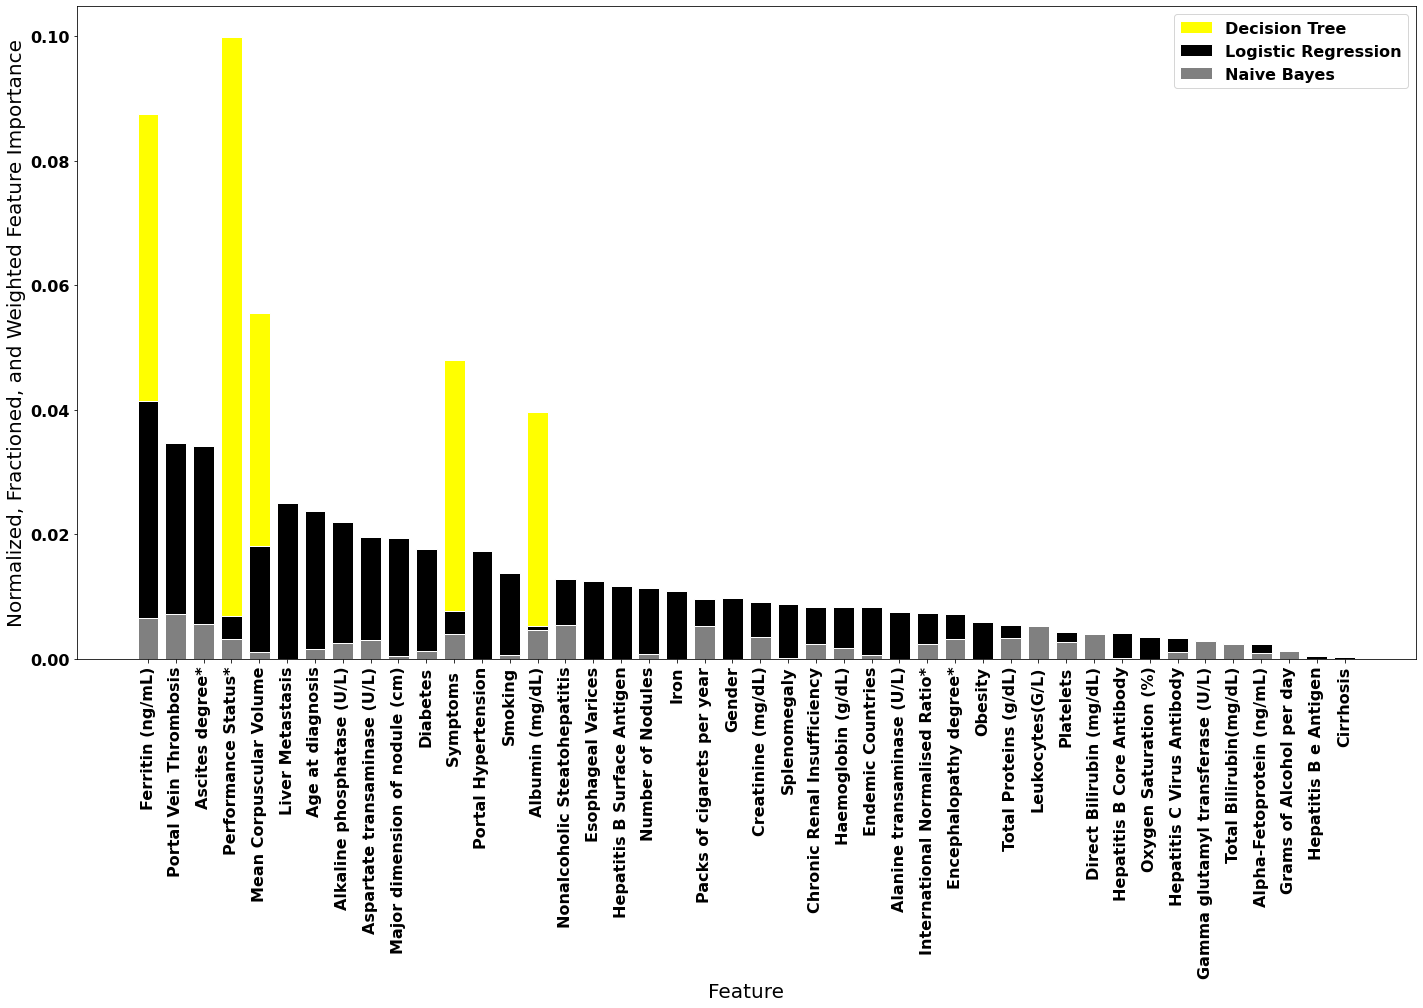

---------------------------------------
hcc-data_example_no_covariates
---------------------------------------


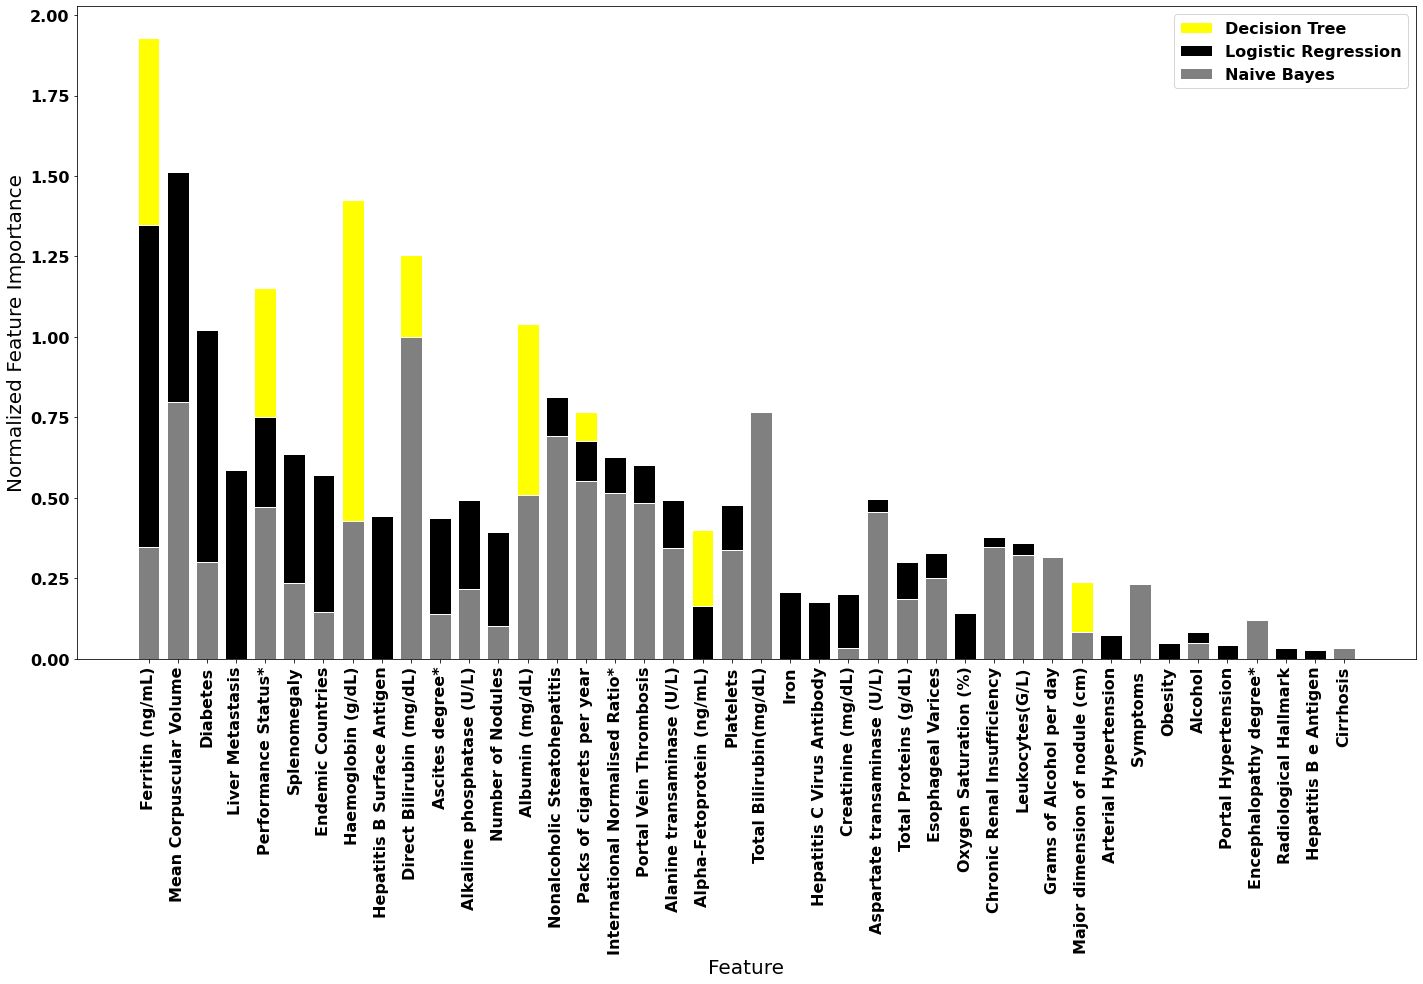

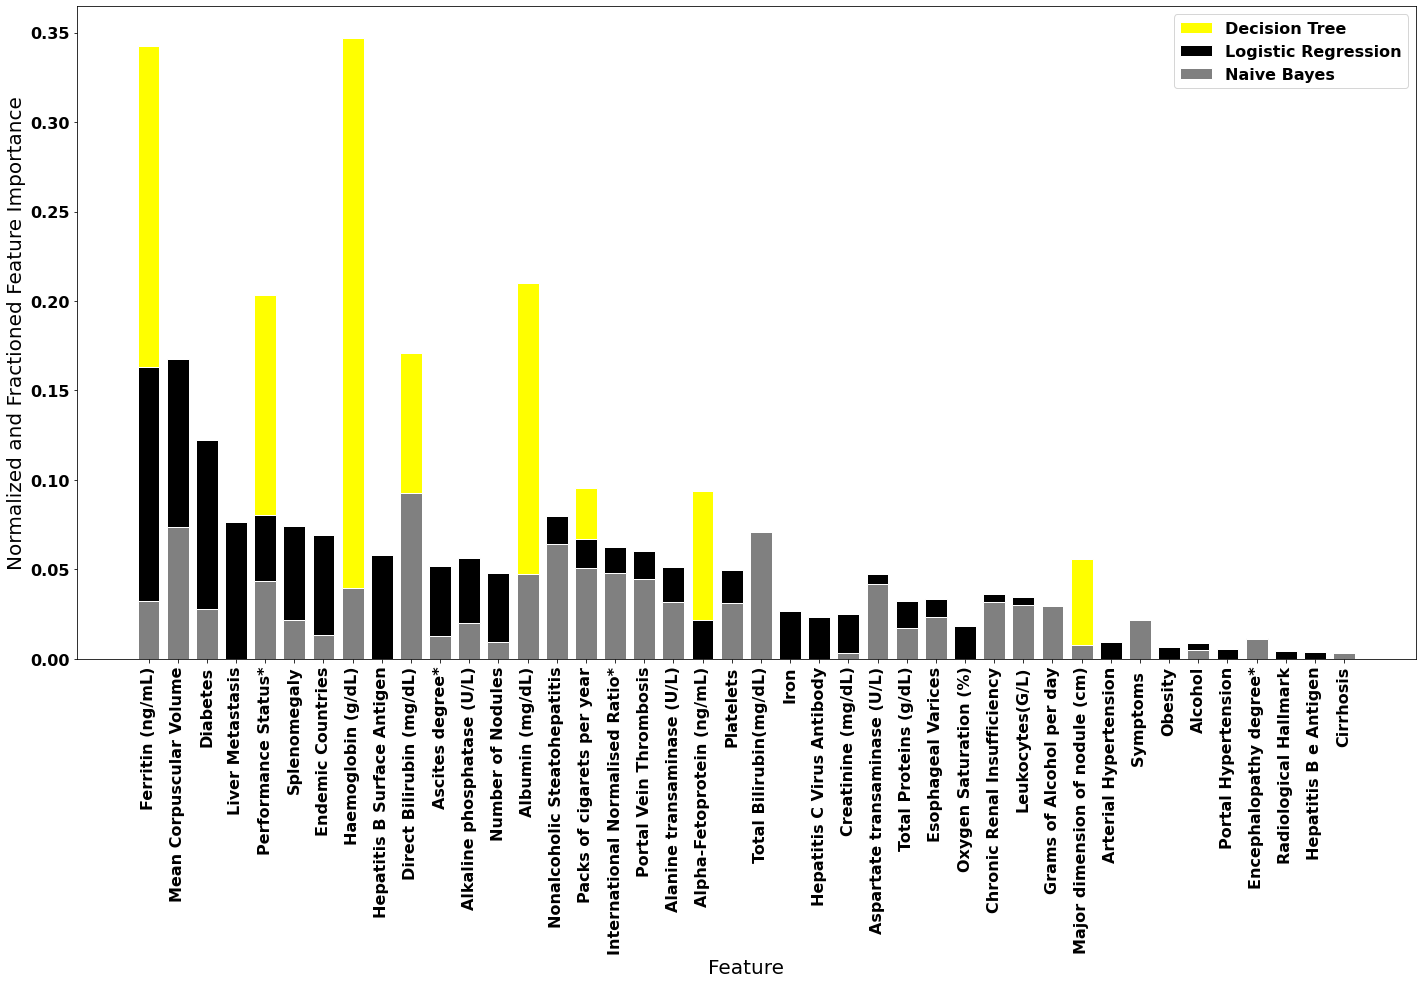

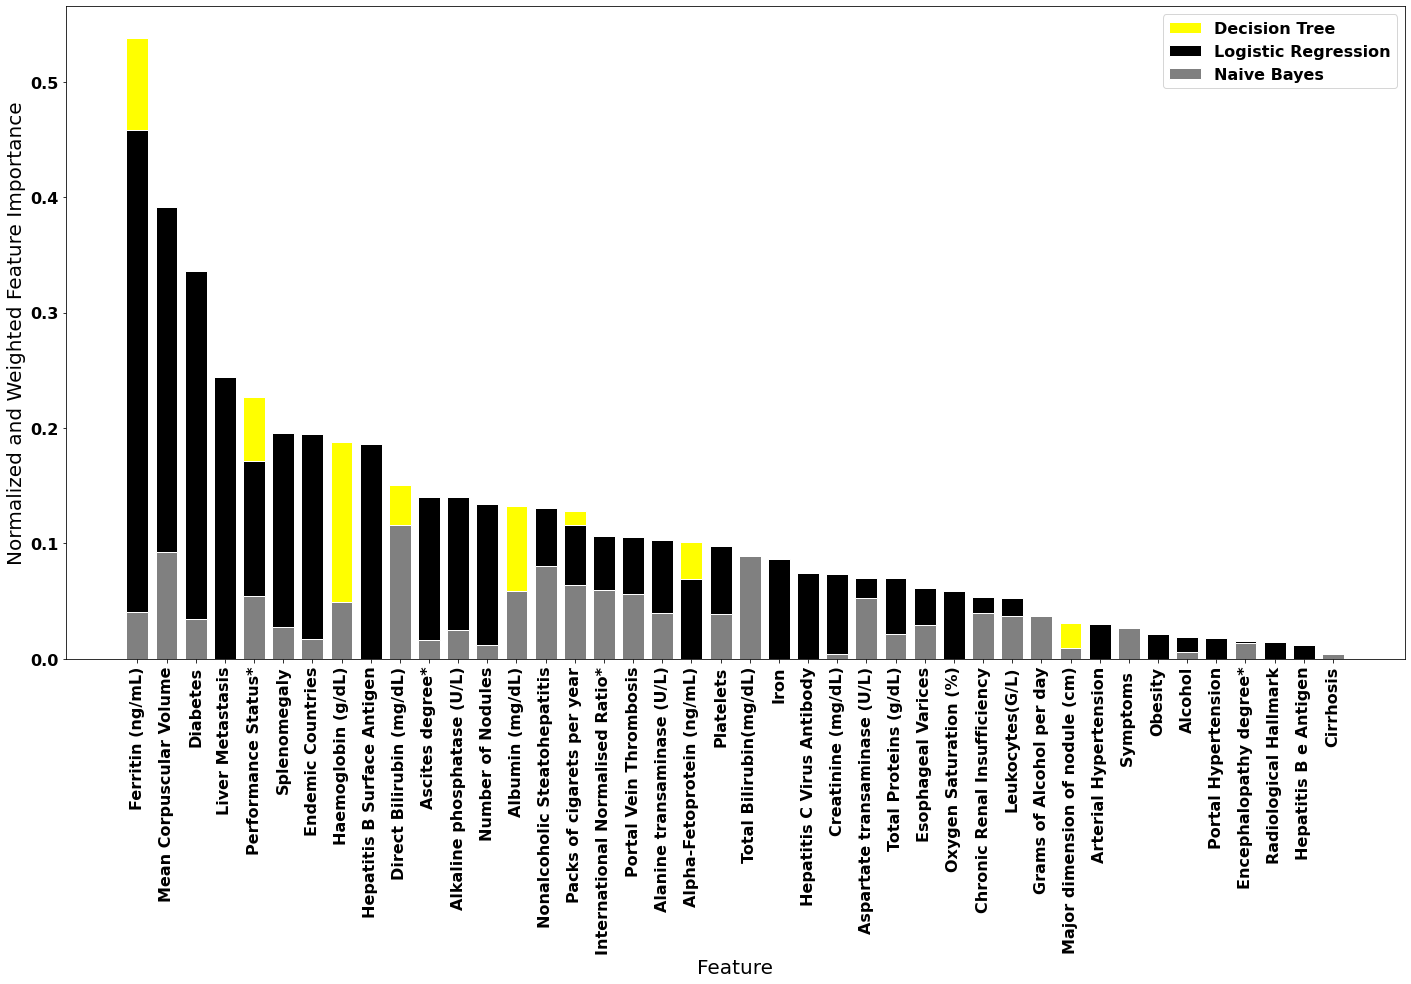

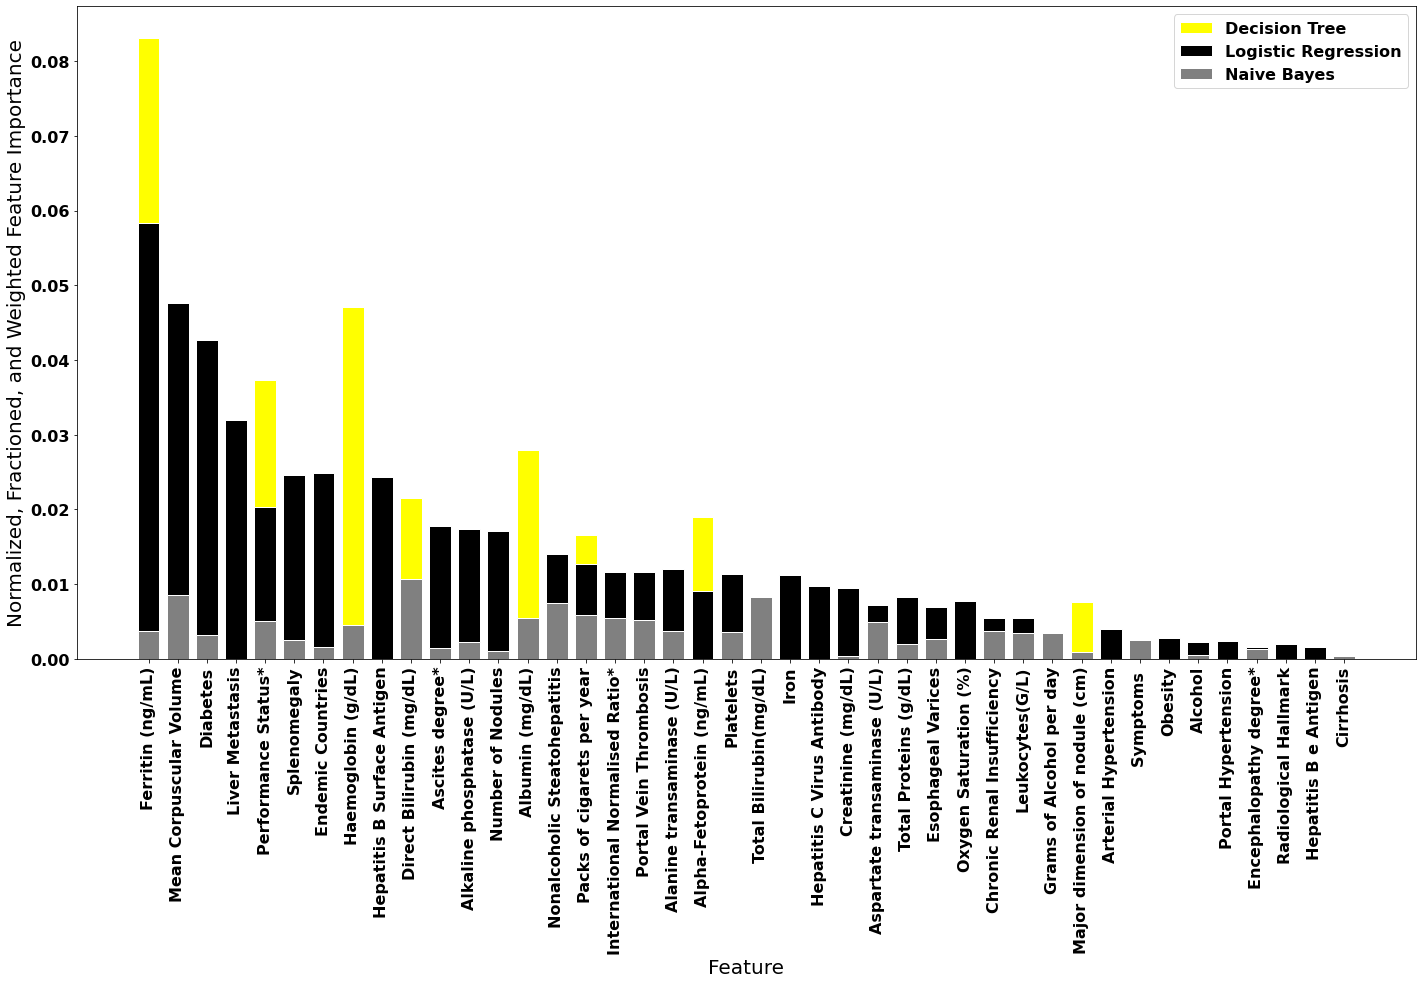

In [13]:
if not targetDataName == 'None': # User specified one analyzed dataset above (if more than one were analyzed)
    for each in datasets:
        if not each == targetDataName:
            datasets.remove(each)
    print("Vizualized Datasets: "+str(datasets))

for each in datasets: #each analyzed dataset to make plots for
    print("---------------------------------------")
    print(each)
    print("---------------------------------------")
    full_path = experiment_path+'/'+each
    #Create folder for tree vizualization files
    original_headers = pd.read_csv(full_path+"/exploratory/OriginalFeatureNames.csv",sep=',').columns.values.tolist() #Get Original Headers
    
    metric_dict = primaryStats(algorithms,original_headers,cv_partitions,full_path,each,instance_label,class_label,abbrev)

    #Prepare for feature importance visualizations
    fi_df_list,fi_ave_norm_list,ave_metric_list,all_feature_list,non_zero_union_features,non_zero_union_indexes = prepFI(algorithms,full_path,abbrev,metric_dict,'Balanced Accuracy')

    #Select 'top' features for composite vizualization
    featuresToViz = selectForViz(top_results,non_zero_union_features,non_zero_union_indexes,algorithms,ave_metric_list,fi_ave_norm_list)
    
    #Take top feature names to vizualize and get associated feature importance values for each algorithm, and original data ordered feature names list
    top_fi_ave_norm_list,all_feature_listToViz = getFI_To_Viz_Sorted(featuresToViz,all_feature_list,algorithms,fi_ave_norm_list) #If we want composite FI plots to be displayed in descenting total bar height order.

    #Generate Normalized composite FI plot
    if viz_norm_only:
        composite_FI_plot(top_fi_ave_norm_list, algorithms, list(colors.values()), all_feature_listToViz, 'Norm',full_path,jupyterRun, 'Normalized Feature Importance',name_modifier,legend_inside_plot)

    #Fractionate FI scores for normalized and fractionated composite FI plot
    fracLists = fracFI(top_fi_ave_norm_list)

    #Generate Normalized and Fractioned composite FI plot
    if viz_norm_frac:
        composite_FI_plot(fracLists, algorithms, list(colors.values()), all_feature_listToViz, 'Norm_Frac',full_path,jupyterRun, 'Normalized and Fractioned Feature Importance',name_modifier,legend_inside_plot)

    #Weight FI scores for normalized and (model performance) weighted composite FI plot
    weightedLists,weights = weightFI(ave_metric_list,top_fi_ave_norm_list)

    #Generate Normalized and Weighted Compount FI plot
    if viz_norm_weight:
        composite_FI_plot(weightedLists, algorithms, list(colors.values()), all_feature_listToViz, 'Norm_Weight',full_path,jupyterRun, 'Normalized and Weighted Feature Importance',name_modifier,legend_inside_plot)

    #Weight the Fractionated FI scores for normalized,fractionated, and weighted compount FI plot
    weightedFracLists = weightFracFI(fracLists,weights)

    #Generate Normalized, Fractionated, and Weighted Compount FI plot
    if viz_norm_weight_frac:
        composite_FI_plot(weightedFracLists, algorithms, list(colors.values()), all_feature_listToViz, 'Norm_Frac_Weight',full_path,jupyterRun, 'Normalized, Fractioned, and Weighted Feature Importance',name_modifier,legend_inside_plot)
    
    